In [56]:
from pathlib import Path
from glob import glob
import pandas as pd
import numpy as np

from alternationprober.constants import (
    PATH_TO_RESULTS_DIRECTORY,
)

import matplotlib.pyplot as plt
import seaborn as sns
import json

In [59]:
def sorting_key(layer_path):
    """Sort the result paths by the final directory, where ``static`` corresponds to layer 0."""
    if layer_path.stem == "static":
        key = 0
    else:
        key = int(layer_path.stem)
    return key

In [189]:
all_df = pd.DataFrame()

models = ['bert-base-uncased', 'roberta-base', 'google/electra-base-discriminator', 'microsoft/deberta-base']
for model in models:
    if '/' in model:
        model = model.split('/')[1]

    experiment_results = PATH_TO_RESULTS_DIRECTORY / "linear-probe-for-sentence-embeddings" / model / "all_results.json"
    with open(experiment_results, 'r') as fp:
        records = []
        lines = fp.readlines()
        for line in lines:
            eval_dict = eval(line)
            records.append(eval_dict)
        
        model_df = pd.DataFrame.from_records(records)
        model_df['model'] = model
        print(model, model_df.shape)
        all_df = all_df.append(model_df)

all_df = all_df[['model', 'alternation', 'layer', 'testing_accuracy', 'test_mcc', 'test_accuracy_bl']]
all_df.columns = ['model', 'alternation', 'layer', 'accuracy', 'mcc', 'baseline_accuracy']
all_df['layer'] += 1

bert-base-uncased (72, 12)
roberta-base (72, 12)
electra-base-discriminator (72, 12)
deberta-base (72, 12)


In [91]:
frames = all_df['alternation'].unique()
frames

array(['combined', 'dative', 'inchoative', 'spray_load', 'there',
       'understood'], dtype=object)

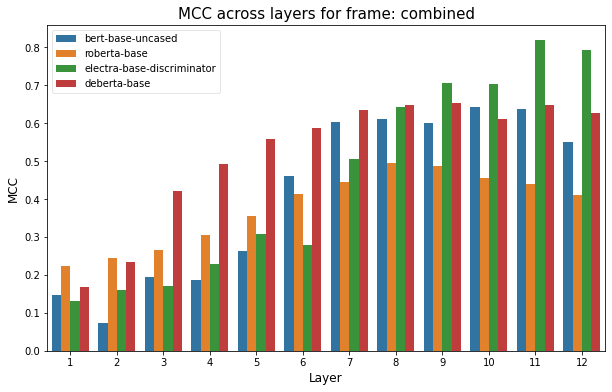

Best Model: electra-base-discriminator (11) MCC: 0.8183684252418135


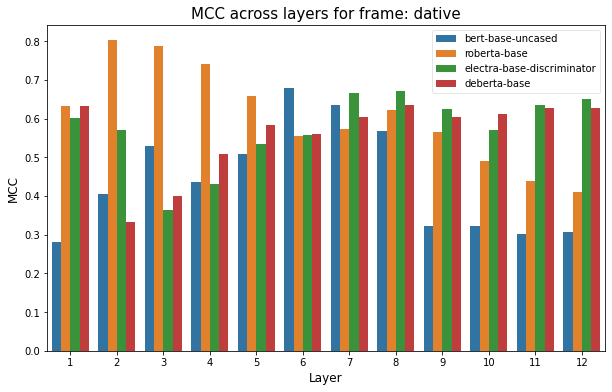

Best Model: roberta-base (2) MCC: 0.8023425916809329


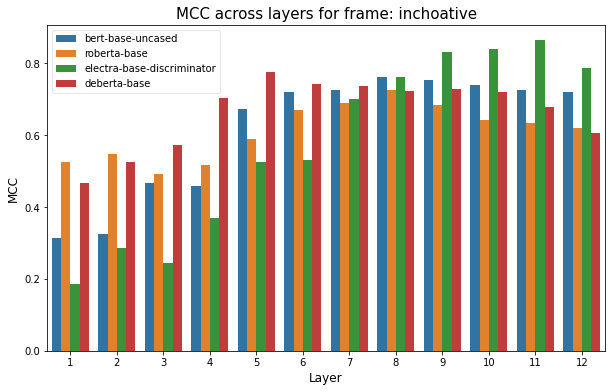

Best Model: electra-base-discriminator (11) MCC: 0.8640733300557201


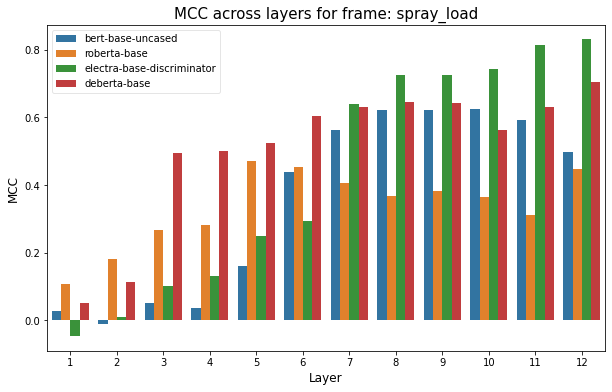

Best Model: electra-base-discriminator (12) MCC: 0.8300930181399085


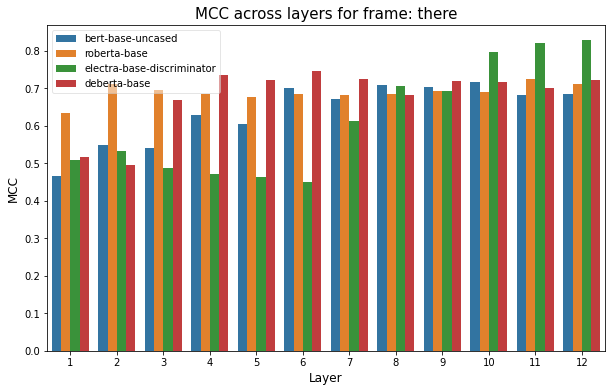

Best Model: electra-base-discriminator (12) MCC: 0.8275281171672219


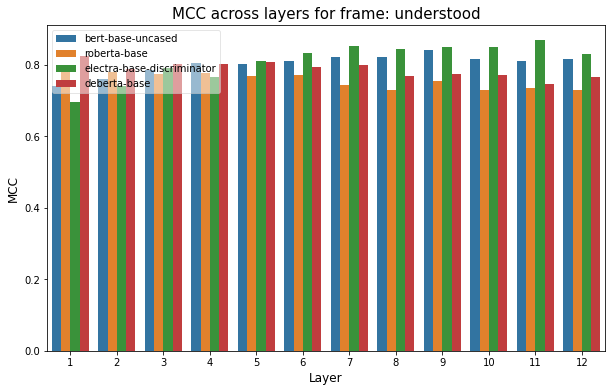

Best Model: electra-base-discriminator (11) MCC: 0.8691336292068832


In [196]:
best_layers = []
best_mccs = []
best_models = []
best_accs = []

for alternation in frames:
    alternation_df = all_df[all_df['alternation'] == alternation].reset_index()
    
    # Store variables to create summary df
    best_row = alternation_df[alternation_df['mcc'] == alternation_df['mcc'].max()]

    best_layer = best_row['layer'].item()
    best_mcc = best_row['mcc'].item()
    best_acc = best_row['accuracy'].item()
    best_model = best_row['model'].item()

    best_layers.append(best_layer)
    best_mccs.append(best_mcc)
    best_models.append(best_model)
    best_accs.append(best_acc)

    # Create barplot
    plt.figure(figsize=(10, 6))
    fig = sns.barplot(x=alternation_df['layer'], y=alternation_df['mcc'], hue=alternation_df['model'])

    plt.title(f'MCC across layers for frame: {alternation}', fontsize=15)
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('MCC', fontsize=12)
    plt.legend(framealpha=0.5)
    plt.show()
    print(f'Best Model: {best_model} ({best_layer}) MCC: {best_mcc}')

In [197]:
best_layer_df = all_df.groupby(['model', 'alternation'])[['mcc', 'accuracy']].max().reset_index()
pd.merge(best_layer_df, all_df, how='left', on=['model', 'alternation', 'mcc', 'accuracy'])[
    ['model', 'layer', 'alternation', 'mcc', 'accuracy']
]

,model,layer,alternation,mcc,accuracy
0,bert-base-uncased,10.0,combined,0.641829,0.840078
1,bert-base-uncased,6.0,dative,0.678074,0.880342
2,bert-base-uncased,8.0,inchoative,0.760328,0.919831
3,bert-base-uncased,10.0,spray_load,0.625235,0.819664
4,bert-base-uncased,10.0,there,0.716170,0.889706
5,bert-base-uncased,9.0,understood,0.842244,0.921384
6,deberta-base,9.0,combined,0.652917,0.847007
7,deberta-base,NaN,dative,0.633940,0.901709
8,deberta-base,5.0,inchoative,0.775585,0.924051
9,deberta-base,12.0,spray_load,0.703901,0.858044


In [139]:
mean_agg = all_df.groupby(['model', 'layer'])[['mcc', 'accuracy']].mean().reset_index()
mean_agg.head()

,model,layer,mcc,accuracy
0,bert-base-uncased,0,0.329307,0.738681
1,bert-base-uncased,1,0.350612,0.745254
2,bert-base-uncased,2,0.428120,0.769389
3,bert-base-uncased,3,0.424870,0.760791
4,bert-base-uncased,4,0.502244,0.788894


Text(0.5, 1.0, 'Mean MCC across Layers')

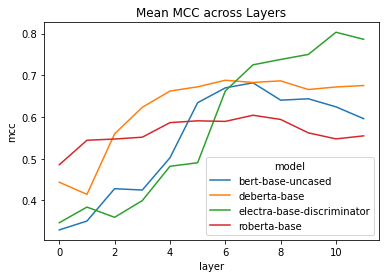

In [152]:
sns.lineplot(x=mean_agg['layer'], y=mean_agg['mcc'], hue=mean_agg['model'])
plt.title('Mean MCC across Layers')

In [153]:
"""
Note: No-there, causative are expected to have 0 MCC since they only have one class
We suspect there is error in the author's evaluation reports, and they switched their metrics for
there/no-there and refl/non-refl
"""

pd.DataFrame(data={
    'Frame': frames,
    'Best Model': best_models,
    'layer': best_layers,
    'Layer MCC': best_mccs,
    'Accuracy': best_accs
    }
)

,Frame,Best Model,layer,Layer MCC,Accuracy
0,combined,electra-base-discriminator,10,0.818368,0.920177
1,dative,roberta-base,1,0.802343,0.944444
2,inchoative,electra-base-discriminator,10,0.864073,0.953586
3,spray_load,electra-base-discriminator,11,0.830093,0.917981
4,there,electra-base-discriminator,11,0.827528,0.936765
5,understood,electra-base-discriminator,10,0.869134,0.933962
